# 01 - Basic GLMs and Inference
The purpose of this file is to:
   * Show use-cases for various GLMs
   * Introduce the statsmodels framework for implementing GLMs
   * Work with some inference techniques to ensure we are creating useful models

In [1]:
import numpy as np
import pandas as pd
import statsmodels.api as sm

import matplotlib.pyplot as plt
%matplotlib inline

## The `statsmodels` API
In what follows, we will explore the statsmodels API, which is a one-stop-shop for all (most) things GLM in Python.  Documentation and examples can be found [here](http://www.statsmodels.org/stable/generated/statsmodels.genmod.generalized_linear_model.GLM.html#statsmodels.genmod.generalized_linear_model.GLM).

## Logistic Regression
Recall that in logistic regression, we have a binary response varialbe coded as 0 or 1.  Formally, a logistic regression is parametrized as follows:

$Y_i \sim \text{iid Bin}(1, p_i)$

$g(p_i) = \mathbf{x}_i^\text{T}\beta = \beta_0 + \beta_1 x_i + \cdots + \beta_p x_p$

Where $p_i = p(\mathbf{x}_i)$ depends on the covariates $\mathbf{x}_i$, and $g$ is the _**link function**_.  The two most common logistic links are:

**Logit link:** $g(p) = \log\left(\frac{p}{1-p}\right) = \text{logit}(p)$

**Probit link:** $g(p) = \Phi^{-1}(p)$ (where $\Phi$ is the standard normal cdf.)

### The Data
The data used from this example come from one of UCLA's amazing IDRE modules (for R).  The module can be found [here](https://stats.idre.ucla.edu/r/dae/logit-regression/).

**Data Description:** _A researcher is interested in how variables, such as GRE (Graduate Record Exam scores), GPA (grade point average) and prestige of the undergraduate institution, effect admission into graduate school. The response variable, admit/don’t admit, is a binary variable._

In [2]:
grad = pd.read_csv("https://stats.idre.ucla.edu/stat/data/binary.csv")

# Let's do some EDA!
print(grad.shape)
grad.head()

(400, 4)


,admit,gre,gpa,rank
0,0,380,3.61,3
1,1,660,3.67,3
2,1,800,4.00,1
3,1,640,3.19,4
4,0,520,2.93,4


In [3]:
grad.describe()

,admit,gre,gpa,rank
count,400.000000,400.000000,400.000000,400.00000
mean,0.317500,587.700000,3.389900,2.48500
std,0.466087,115.516536,0.380567,0.94446
min,0.000000,220.000000,2.260000,1.00000
25%,0.000000,520.000000,3.130000,2.00000
50%,0.000000,580.000000,3.395000,2.00000
75%,1.000000,660.000000,3.670000,3.00000
max,1.000000,800.000000,4.000000,4.00000


In [4]:
grad.admit.value_counts()

0    273
1    127
Name: admit, dtype: int64

array([<matplotlib.axes._subplots.AxesSubplot object at 0x0000029500243748>,
       <matplotlib.axes._subplots.AxesSubplot object at 0x0000029500284550>], dtype=object)

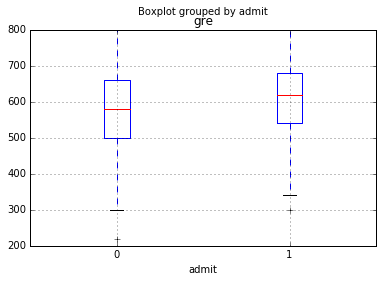

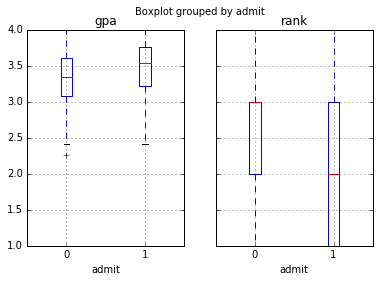

In [5]:
grad.boxplot('gre', by = 'admit')
grad.boxplot(['gpa', 'rank'], by = 'admit')


In [6]:
# Now, let's build our GLM
indep_vars = ['gre', 'gpa', 'rank']
x_mat = sm.add_constant(grad[indep_vars])
y_vec = grad.admit
glm_logit = sm.GLM(y_vec, 
                   x_mat,
                   sm.families.Binomial(sm.families.links.logit)).fit()

In [7]:
glm_logit.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                 Generalized Linear Model Regression Results                  
==============================================================================
Dep. Variable:                  admit   No. Observations:                  400
Model:                            GLM   Df Residuals:                      396
Model Family:                Binomial   Df Model:                            3
Link Function:                  logit   Scale:                             1.0
Method:                          IRLS   Log-Likelihood:                -229.72
Date:                Thu, 20 Jul 2017   Deviance:                       459.44
Time:                        19:34:39   Pearson chi2:                     399.
No. Iterations:                     6                                         
==============================================================================
                 coef    std err          z      P>|z|      [95.0% Conf. Int.]
------------------------------------------------------------------------------
const         -3.4495      1.133     -3.045      0.002        -5.670    -1.229
gre            0.0023      0.001      2.101      0.036         0.000     0.004
gpa            0.7770      0.327      2.373      0.018         0.135     1.419
rank          -0.5600      0.127     -4.405      0.000        -0.809    -0.311
==============================================================================
"""

### Discussion:
What can you tell me about this output?
* What do the z-statistics tell you?
* If I scored 100 points better on my GRE, how would that affect my odds of acceptance?
* What do you think the number of IRLS interations can tell us?
* Overall, is this a good model fit? (_Without looking at classification accuracy_...)

In [8]:
# Next, let's see if we can safely reduce our model
reduced_vars = ['gre', 'gpa']
x_reduced = sm.add_constant(grad[reduced_vars])
glm_reduced = sm.GLM(y_vec,
                    x_reduced,
                    sm.families.Binomial(sm.families.links.logit)).fit()
glm_reduced.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                 Generalized Linear Model Regression Results                  
==============================================================================
Dep. Variable:                  admit   No. Observations:                  400
Model:                            GLM   Df Residuals:                      397
Model Family:                Binomial   Df Model:                            2
Link Function:                  logit   Scale:                             1.0
Method:                          IRLS   Log-Likelihood:                -240.17
Date:                Thu, 20 Jul 2017   Deviance:                       480.34
Time:                        19:34:39   Pearson chi2:                     398.
No. Iterations:                     6                                         
==============================================================================
                 coef    std err          z      P>|z|      [95.0% Conf. Int.]
------------------------------------------------------------------------------
const         -4.9494      1.075     -4.604      0.000        -7.057    -2.842
gre            0.0027      0.001      2.544      0.011         0.001     0.005
gpa            0.7547      0.320      2.361      0.018         0.128     1.381
==============================================================================
"""

In [9]:
# Test model differences
from scipy.stats import chi2

D = glm_reduced.deviance - glm_logit.deviance
print('Difference in Deviance: ', D)
pval = 1 - chi2.cdf(D, df = 1)
print('p-value of test of difference: ', pval) # What can we conclude here?

Difference in Deviance:  20.9022166536
p-value of test of difference:  4.83334960077e-06


### Poisson Regression Example
Recall the formal definition of a Poisson regression:

$Y_i \sim \text{iid Poi}(\lambda_i)$

$\log (\lambda_i) = \mathbf{x}_i^\text{T}\beta = \beta_0 + \beta_1 x_1 + \cdots + \beta_p x_p$

where, again, $\lambda_i = \lambda(\mathbf{x}_i)$ depends on $\mathbf{x}_i$.

#### Data
We'll again rely on UCLA's IDRE module.  This one can be found [here](https://stats.idre.ucla.edu/r/dae/poisson-regression/).

#### Data Description
_The number of awards earned by students at one high school. Predictors of the number of awards earned include the type of program in which the student was enrolled (e.g., vocational, general or academic) and the score on their final exam in math._

In [10]:
award = pd.read_csv("https://stats.idre.ucla.edu/stat/data/poisson_sim.csv")

# Let's do some EDA:
award.head()

,id,num_awards,prog,math
0,45,0,3,41
1,108,0,1,41
2,15,0,3,44
3,67,0,3,42
4,153,0,3,40


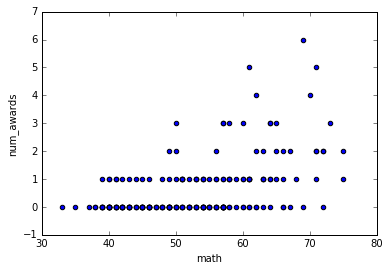

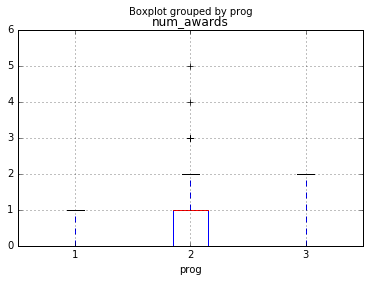

In [11]:
award.plot('math', 'num_awards', kind = 'scatter')
award.boxplot('num_awards', by = 'prog') # Oh no - this is hideous.  Why can't everything be ggplot?

In [12]:
# Notice that prog is actually a categorical variable - I am aware of this.
# I'm going to suspsend that knowledge for the sake of example.
poi_vars = ['prog', 'math']
x_poi = sm.add_constant(award[poi_vars])
y_poi = award.num_awards

glm_poi = sm.GLM(y_poi,
                 x_poi,
                 family = sm.families.Poisson()).fit()
glm_poi.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                 Generalized Linear Model Regression Results                  
==============================================================================
Dep. Variable:             num_awards   No. Observations:                  200
Model:                            GLM   Df Residuals:                      197
Model Family:                 Poisson   Df Model:                            2
Link Function:                    log   Scale:                             1.0
Method:                          IRLS   Log-Likelihood:                -189.75
Date:                Thu, 20 Jul 2017   Deviance:                       203.45
Time:                        19:34:40   Pearson chi2:                     227.
No. Iterations:                     8                                         
==============================================================================
                 coef    std err          z      P>|z|      [95.0% Conf. Int.]
------------------------------------------------------------------------------
const         -5.5781      0.677     -8.242      0.000        -6.905    -4.252
prog           0.1233      0.163      0.755      0.450        -0.197     0.443
math           0.0861      0.010      8.984      0.000         0.067     0.105
==============================================================================
"""

In [13]:
# Interesting - it looks like prog is pretty insignificant.
# Let's try removing it and seeing what happens.
x_poi_red = sm.add_constant(award.math)

glm_poi_red = sm.GLM(y_poi,
                     x_poi_red,
                     family = sm.families.Poisson()).fit()
glm_poi_red.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                 Generalized Linear Model Regression Results                  
==============================================================================
Dep. Variable:             num_awards   No. Observations:                  200
Model:                            GLM   Df Residuals:                      198
Model Family:                 Poisson   Df Model:                            1
Link Function:                    log   Scale:                             1.0
Method:                          IRLS   Log-Likelihood:                -190.04
Date:                Thu, 20 Jul 2017   Deviance:                       204.02
Time:                        19:34:40   Pearson chi2:                     229.
No. Iterations:                     8                                         
==============================================================================
                 coef    std err          z      P>|z|      [95.0% Conf. Int.]
------------------------------------------------------------------------------
const         -5.3335      0.591     -9.021      0.000        -6.492    -4.175
math           0.0862      0.010      8.902      0.000         0.067     0.105
==============================================================================
"""

In [14]:
# Test model difference:
D_poi = glm_poi_red.deviance - glm_poi.deviance
print('Difference in Deviance: ', D_poi)
pval_poi = 1 - chi2.cdf(D_poi, 1)
print('p-value of test of difference: ', pval_poi) # What does this mean?

Difference in Deviance:  0.570112255084
p-value of test of difference:  0.450214312654
